# Telco Customer Churn — Feature Engineering, Interactions & Explainable ML

In [107]:
# 1. to handle the data
import pandas as pd
import numpy as np
from scipy import stats

# to visualize the data
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px

# To preprocess the data
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder,OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE

# import iterative imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
#for classification tasks
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestRegressor
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

# pipeline
from sklearn.pipeline import Pipeline

# metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_absolute_error,mean_squared_error,r2_score

# ignore warnings   
import warnings
warnings.filterwarnings('ignore')

##  Goals
- Perform thorough EDA and cleaning.
- Create meaningful new features and interaction terms.
- Train strong baseline and tuned models.
- Produce explainable feature importance (global + local) using SHAP.
- Provide actionable business insights for retention strategies.


In [108]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Step 2 — Quick EDA (Exploratory Data Analysis)

Goal:
- Get a fast and clear overview of the dataset: shape, dtypes, missing values, basic stats.
- Inspect target distribution (`Churn`) and unique counts for categorical features.

What we will check:
1. Dataset shape and head
2. Column data types and non-null counts
3. Summary statistics for numerical features
4. Missing values (count + percentage)
5. Unique counts for categorical features (top for each)
6. Target (`Churn`) distribution (counts + percentage)


In [109]:
print("Shape:", df.shape)
display(df.head())

print("\n--- DataFrame info ---")
display(df.info())

print("\n--- Numerical summary ---")
display(df.describe().T)

missing = df.isnull().sum().rename("missing_count")
missing_pct = (df.isnull().mean() * 100).rename("missing_pct")
missing_df = pd.concat([missing, missing_pct], axis = 1).sort_values("missing_pct", ascending = False)
print("\n--- Missing values (count & % ) ---")
display(missing_df)

cat_cols = df.select_dtypes(include = ["object"]).columns.tolist()
print(f"\nCategorical columns ({len(cat_cols)}): {cat_cols}\n")
cat_unique = pd.DataFrame({
    "col": cat_cols,
    "n_unique": [df[c].nunique() for c in cat_cols],
    "top_values_sample": [df[c].value_counts().index[:5].tolist() for c in cat_cols]
}).sort_values("n_unique", ascending = False)
print("--- Categorical unique counts & top values ---")
display(cat_unique.reset_index(drop = True))

churn_counts = df['Churn'].value_counts(dropna = False)
churn_pct = df['Churn'].value_counts(normalize = True, dropna = False) * 100
churn_df = pd.concat([churn_counts.rename("count"), churn_pct.rename("percent")], axis = 1)
print("\n--- Target distribution: Churn ---")
display(churn_df)


Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



--- DataFrame info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  

None


--- Numerical summary ---


,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75



--- Missing values (count & % ) ---


,missing_count,missing_pct
customerID,0,0.0
DeviceProtection,0,0.0
TotalCharges,0,0.0
MonthlyCharges,0,0.0
PaymentMethod,0,0.0
PaperlessBilling,0,0.0
Contract,0,0.0
StreamingMovies,0,0.0
StreamingTV,0,0.0
TechSupport,0,0.0



Categorical columns (18): ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges', 'Churn']

--- Categorical unique counts & top values ---


,col,n_unique,top_values_sample
0,customerID,7043,"[7590-VHVEG, 3791-LGQCY, 6008-NAIXK, 5956-YHHR..."
1,TotalCharges,6531,"[ , 20.2, 19.75, 20.05, 19.9]"
2,PaymentMethod,4,"[Electronic check, Mailed check, Bank transfer..."
3,OnlineBackup,3,"[No, Yes, No internet service]"
4,Contract,3,"[Month-to-month, Two year, One year]"
5,StreamingMovies,3,"[No, Yes, No internet service]"
6,StreamingTV,3,"[No, Yes, No internet service]"
7,TechSupport,3,"[No, Yes, No internet service]"
8,DeviceProtection,3,"[No, Yes, No internet service]"
9,OnlineSecurity,3,"[No, Yes, No internet service]"



--- Target distribution: Churn ---


,count,percent
Churn,,
No,5174,73.463013
Yes,1869,26.536987


## Step 3 — Data Cleaning & Preparation

Key steps:
1. Convert `TotalCharges` to numeric (it is loaded as object).
2. Handle invalid entries (empty strings → NaN → impute or drop).
3. Strip whitespaces from string columns (just in case).


In [110]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors = "coerce")

missing_total = df["TotalCharges"].isnull().sum()
print(f"Missing values in TotalCharges after conversion: {missing_total}")

df = df.dropna(subset = ["TotalCharges"])

cat_cols = df.select_dtypes(include = ["object"]).columns
for col in cat_cols:
    df[col] = df[col].str.strip()

print("Data cleaning completed.")
print("Shape after cleaning:", df.shape)


Missing values in TotalCharges after conversion: 11
Data cleaning completed.
Shape after cleaning: (7032, 21)


## Step 4 — Feature Overview & Target Encoding

What we will do:
1. Encode target `Churn` into binary (Yes → 1, No → 0).
2. Separate features into **numerical** and **categorical** lists.
3. Summarize all columns with:
   - dtype
   - number of unique values
   - sample unique values (up to 5)


In [111]:
print("Original Churn unique values:", df["Churn"].unique())

df["Churn"] = df["Churn"].astype(str).str.strip().str.upper()  

df["Churn"] = df["Churn"].map({"YES": 1, "NO": 0})

print("Churn value counts after mapping:")
print(df["Churn"].value_counts(dropna = False))

numerical_cols = df.select_dtypes(include = [np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include = ["object"]).columns.tolist()

print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)

summary = pd.DataFrame({
    "dtype": df.dtypes,
    "n_unique": df.nunique(),
    "sample_values": df.apply(lambda x: x.unique()[:5])
})
display(summary)


Original Churn unique values: ['No' 'Yes']
Churn value counts after mapping:
Churn
0    5163
1    1869
Name: count, dtype: int64
Numerical columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']
Categorical columns: ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


,dtype,n_unique,sample_values
customerID,object,7032,"[7590-VHVEG, 5575-GNVDE, 3668-QPYBK, 7795-CFOC..."
gender,object,2,"[Female, Male]"
SeniorCitizen,int64,2,"[0, 1]"
Partner,object,2,"[Yes, No]"
Dependents,object,2,"[No, Yes]"
tenure,int64,72,"[1, 34, 2, 45, 8]"
PhoneService,object,2,"[No, Yes]"
MultipleLines,object,3,"[No phone service, No, Yes]"
InternetService,object,3,"[DSL, Fiber optic, No]"
OnlineSecurity,object,3,"[No, Yes, No internet service]"


## Step 5 — Target & Categorical Distributions Visualization

Goals:
1. Visualize target distribution (`Churn`).
2. Explore key categorical variables with count plots.
3. Add count annotations to bars for clarity.


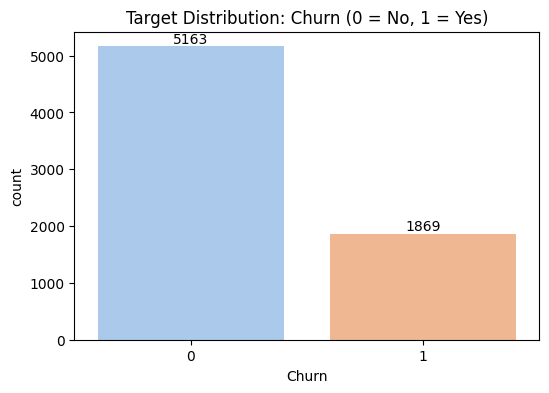

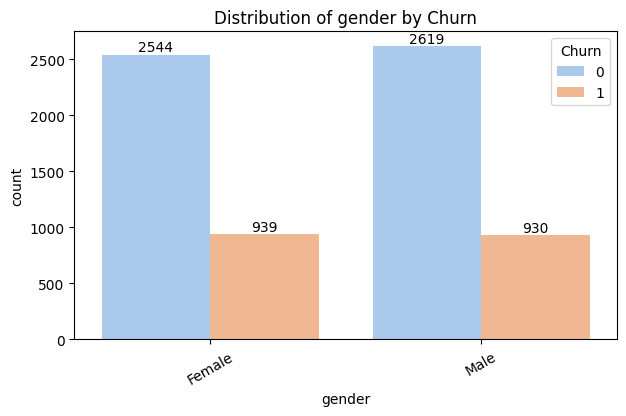

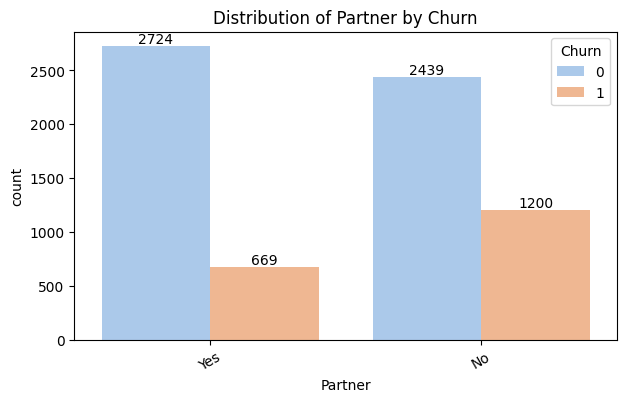

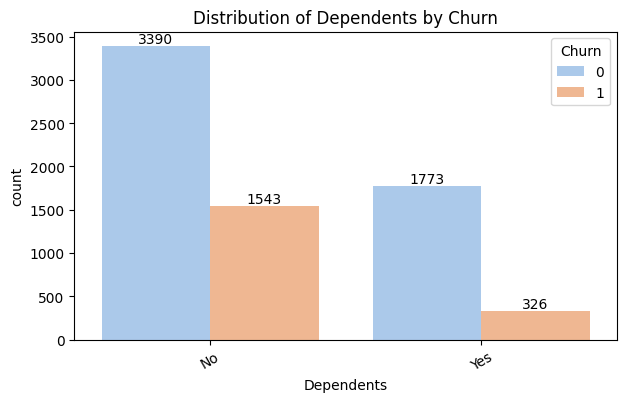

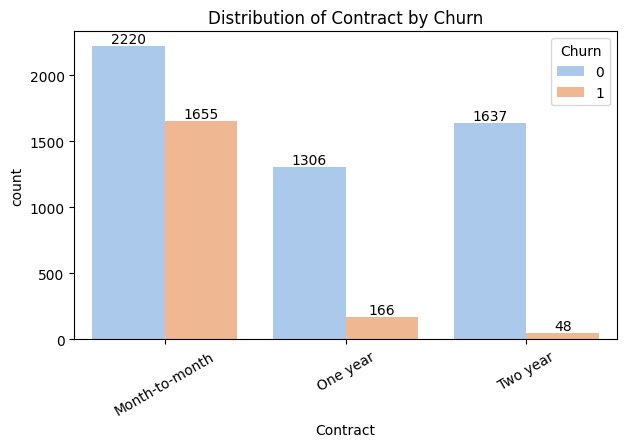

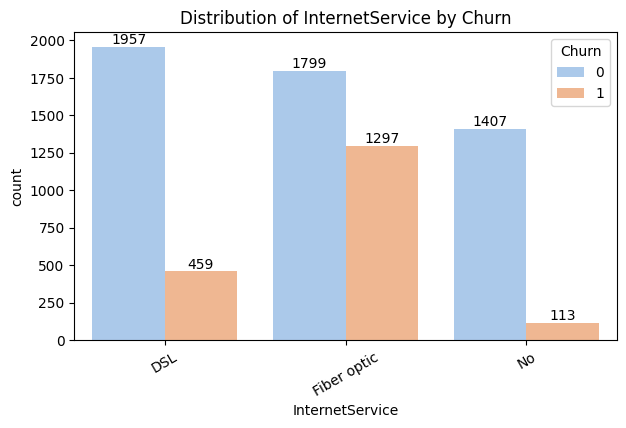

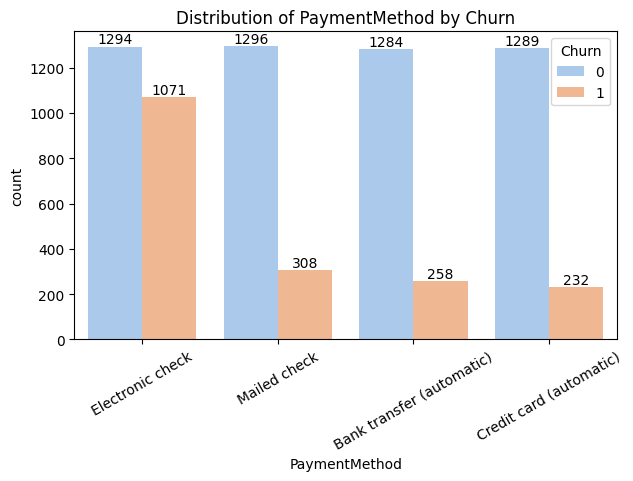

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns

def countplot_with_churn(col, df, hue = "Churn", palette = "pastel", figsize = (7, 4)):
    plt.figure(figsize = figsize)
    ax = sns.countplot(data = df, x = col, hue = hue, palette = palette)
    plt.title(f"Distribution of {col} by {hue}")
    plt.xticks(rotation = 30)
    
    for container in ax.containers:
        labels = [str(int(bar.get_height())) for bar in container]
        ax.bar_label(container, labels = labels)
    plt.show()

plt.figure(figsize = (6, 4))
ax = sns.countplot(data = df, x = "Churn", palette = "pastel")
for container in ax.containers:
    labels = [str(int(bar.get_height())) for bar in container]
    ax.bar_label(container, labels = labels)
plt.title("Target Distribution: Churn (0 = No, 1 = Yes)")
plt.show()

cat_vars = ["gender", "Partner", "Dependents", "Contract", "InternetService", "PaymentMethod"]

for col in cat_vars:
    countplot_with_churn(col, df)


## Step 6 — Numerical Distributions & Correlation with Churn

**Goals:**
1. Visualize the distribution of key numerical features (`tenure`, `MonthlyCharges`, `TotalCharges`) using histograms.
2. Compare numerical features across Churn values using boxplots and violin plots.
3. Examine correlation of numerical features with the target (`Churn`) to identify potential important predictors.

**Notes:**
- Histograms help to understand general distribution (skewness, outliers).
- Boxplots and violin plots highlight differences between customers who churned vs. not.
- Correlation provides a quick numerical insight into which features might be more predictive.


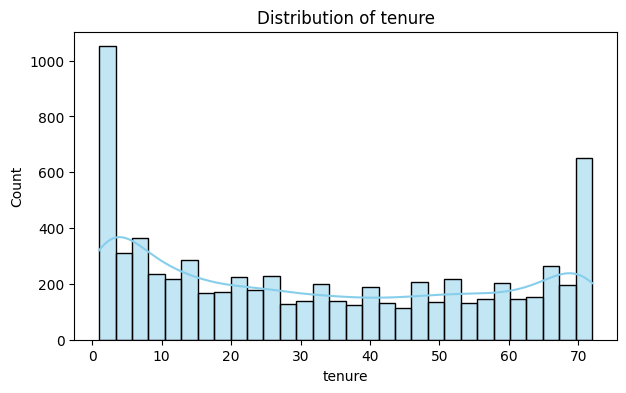

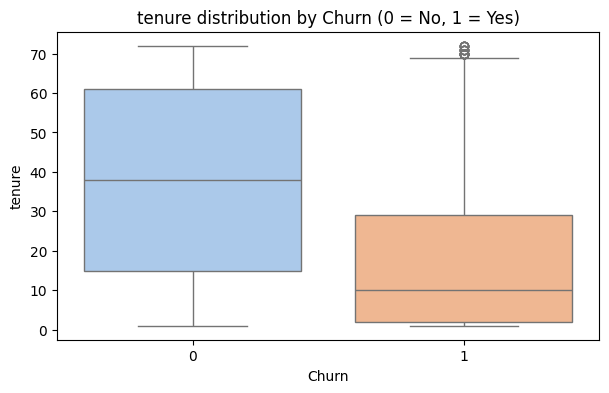

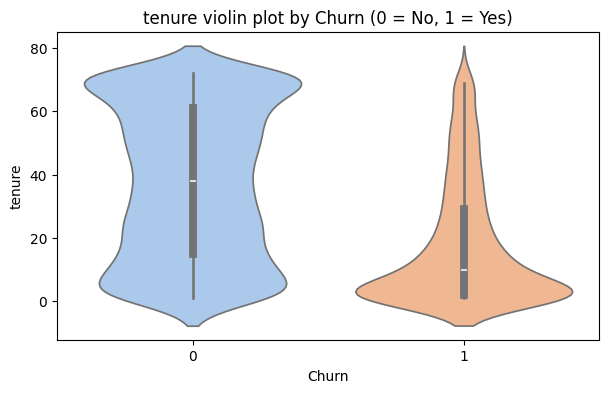

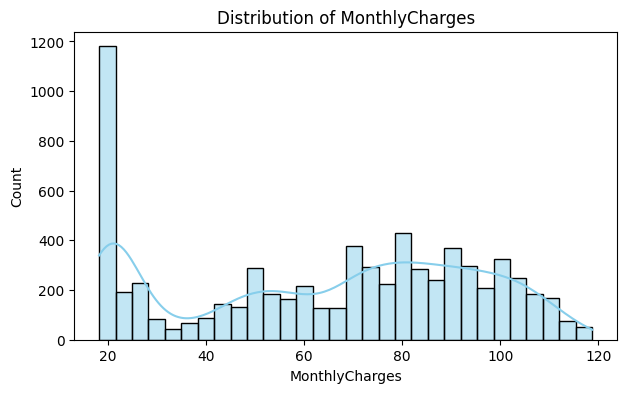

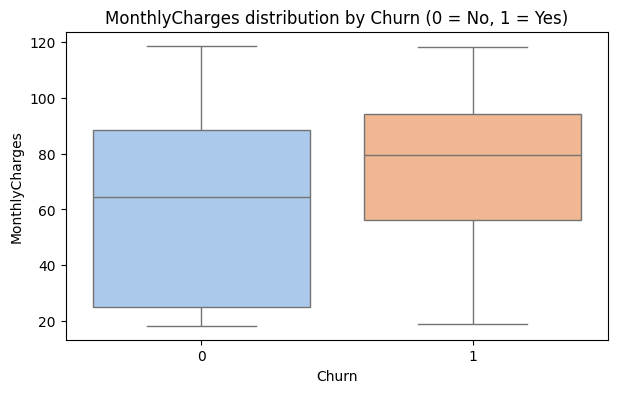

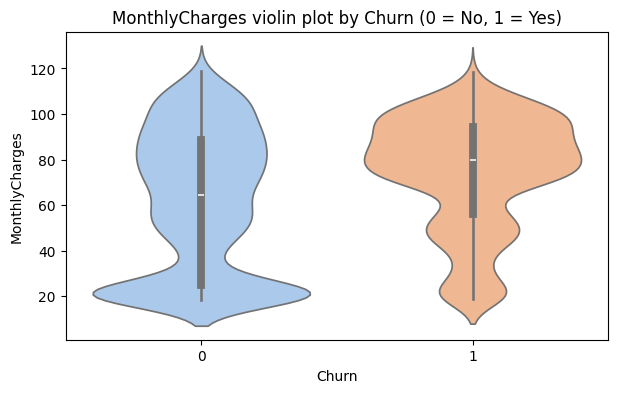

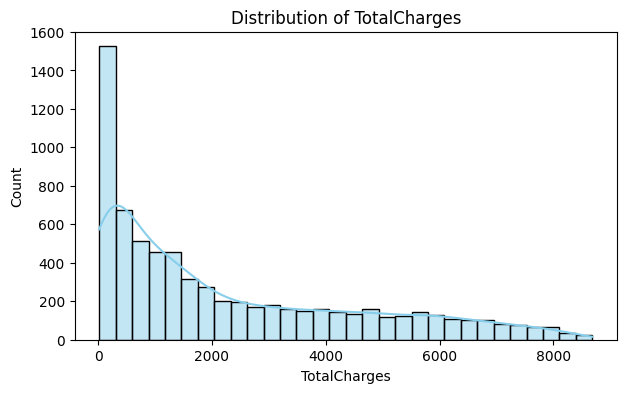

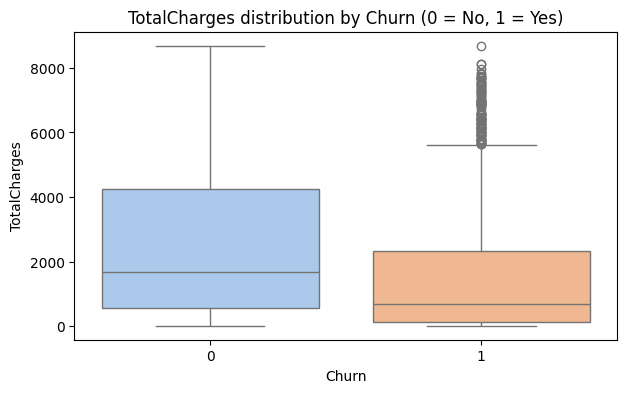

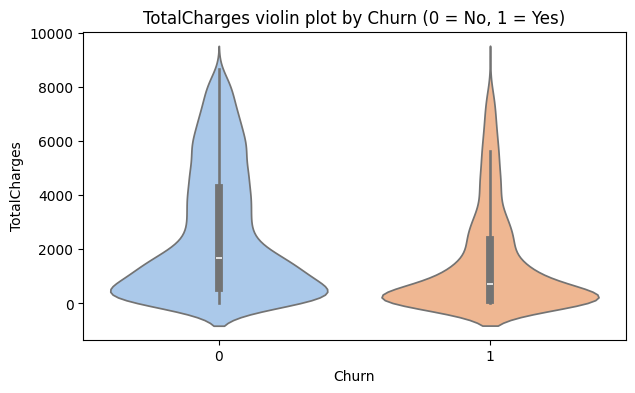

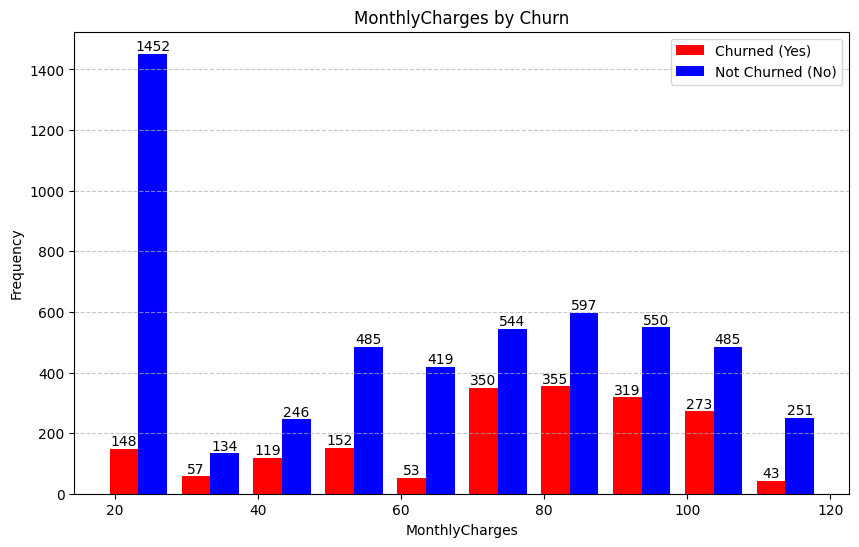

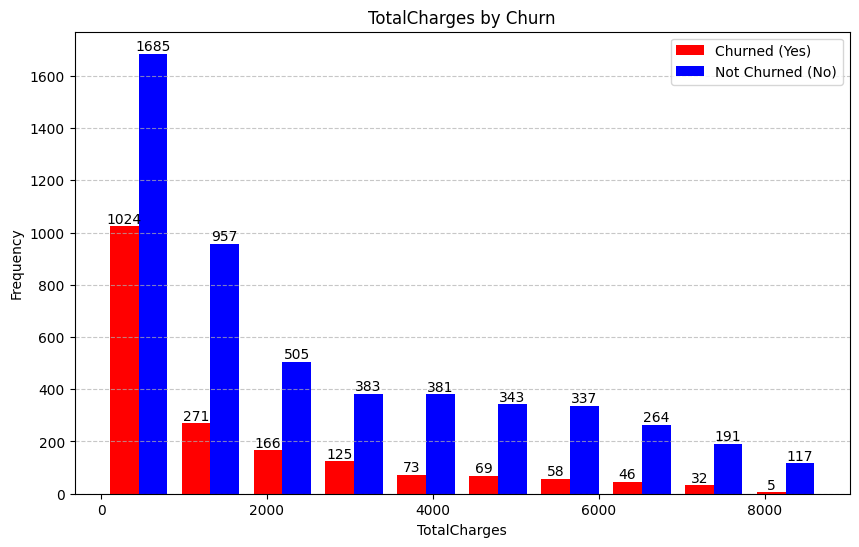

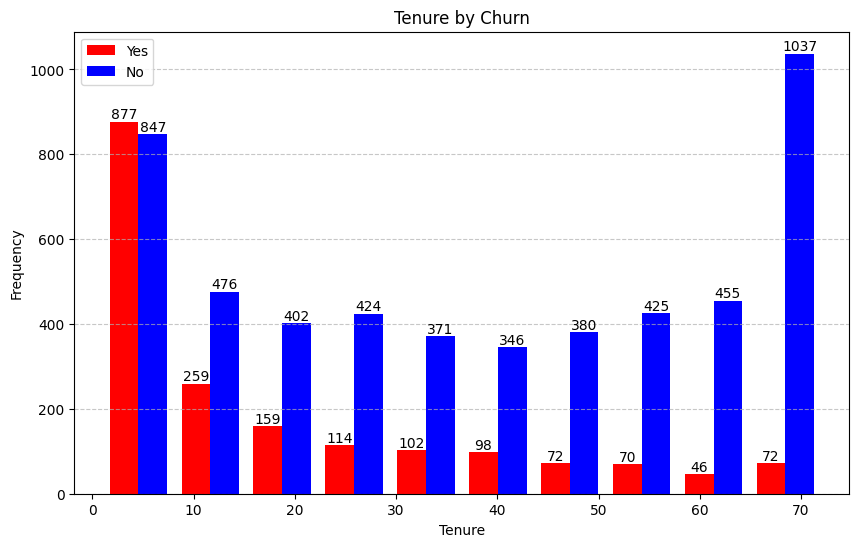

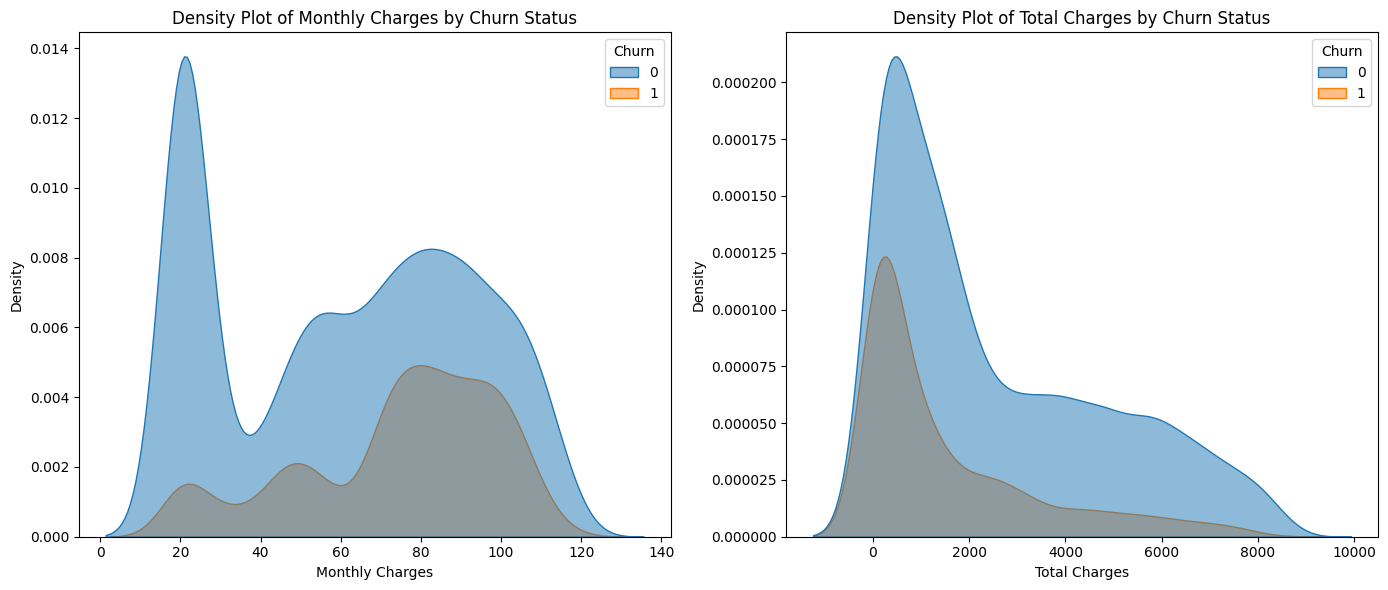

In [113]:
numerical_cols = ["tenure", "MonthlyCharges", "TotalCharges"]

for col in numerical_cols:
    plt.figure(figsize=(7, 4))
    sns.histplot(data=df, x=col, kde=True, bins=30, color="skyblue")
    plt.title(f"Distribution of {col}")
    plt.show()
    
    plt.figure(figsize=(7, 4))
    sns.boxplot(data=df, x="Churn", y=col, palette="pastel")
    plt.title(f"{col} distribution by Churn (0 = No, 1 = Yes)")
    plt.show()
    
    plt.figure(figsize=(7, 4))
    sns.violinplot(data=df, x="Churn", y=col, palette="pastel")
    plt.title(f"{col} violin plot by Churn (0 = No, 1 = Yes)")
    plt.show()

# Histograms with counts on top for MonthlyCharges and TotalCharges
for col in ["MonthlyCharges", "TotalCharges"]:
    churned = df[df['Churn'] == 1]
    not_churned = df[df['Churn'] == 0]
    
    plt.figure(figsize=(10, 6))
    plt.hist([churned[col], not_churned[col]], bins=10, color=['red', 'blue'], label=['Churned (Yes)', 'Not Churned (No)'])
    plt.title(f'{col} by Churn')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    for rect in plt.gca().patches:
        height = rect.get_height()
        plt.gca().text(rect.get_x() + rect.get_width() / 2, height, int(height), ha='center', va='bottom')
    
    plt.show()

# Tenure histogram as per your original code
churned = df[df['Churn'] == 1]
not_churned = df[df['Churn'] == 0]

plt.figure(figsize=(10, 6))
plt.hist([churned['tenure'], not_churned['tenure']], bins=10, color=['red', 'blue'], label=['Yes', 'No'])
plt.title('Tenure by Churn')
plt.xlabel('Tenure')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

for rect in plt.gca().patches:
    height = rect.get_height()
    plt.gca().text(rect.get_x() + rect.get_width() / 2, height, int(height), ha='center', va='bottom')

plt.show()

# KDE density plots side by side for MonthlyCharges and TotalCharges
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.kdeplot(data=df, x="MonthlyCharges", hue="Churn", fill=True, alpha=0.5, ax=axes[0])
axes[0].set_title('Density Plot of Monthly Charges by Churn Status')
axes[0].set_xlabel('Monthly Charges')
axes[0].set_ylabel('Density')

sns.kdeplot(data=df, x="TotalCharges", hue="Churn", fill=True, alpha=0.5, ax=axes[1])
axes[1].set_title('Density Plot of Total Charges by Churn Status')
axes[1].set_xlabel('Total Charges')
axes[1].set_ylabel('Density')

plt.tight_layout()
plt.show()


## Step 7 — Feature Engineering (New Features + Interaction)

**Goals:**
1. Create new features based on existing ones to capture more signal.
2. Generate feature interactions that could be predictive of Churn.
3. Keep transformations simple and interpretable for business insight.


In [114]:
df["AvgChargesPerMonth"] = df["TotalCharges"] / df["tenure"]

df["tenure_group"] = pd.cut(df["tenure"], bins = [0, 12, 24, 48, 60, 72], 
                             labels = ["0-12", "13-24", "25-48", "49-60", "61-72"])

df["Contract_Payment"] = df["Contract"] + "_" + df["PaymentMethod"]

df["HighMonthlyCharges"] = (df["MonthlyCharges"] > df["MonthlyCharges"].median()).astype(int)

df["LongTenure"] = (df["tenure"] > 48).astype(int)

display(df[["AvgChargesPerMonth", "tenure_group", "Contract_Payment", "HighMonthlyCharges", "LongTenure"]].head())


,AvgChargesPerMonth,tenure_group,Contract_Payment,HighMonthlyCharges,LongTenure
0,29.850000,0-12,Month-to-month_Electronic check,0,0
1,55.573529,25-48,One year_Mailed check,0,0
2,54.075000,0-12,Month-to-month_Mailed check,0,0
3,40.905556,25-48,One year_Bank transfer (automatic),0,0
4,75.825000,0-12,Month-to-month_Electronic check,1,0


## Step 8 — Encoding & Scaling

**Goals:**
1. Encode categorical features for machine learning models.
   - Use One-Hot Encoding for nominal categories.
   - Label Encoding can be used for binary features.
2. Scale numerical features if needed (especially for non-tree models).
3. Keep transformed dataset ready for modeling.


In [115]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

categorical_cols = df.select_dtypes(include = ["object"]).columns.tolist()
categorical_cols = [col for col in categorical_cols if col != "customerID"]

df_encoded = pd.get_dummies(df, columns = categorical_cols, drop_first = True)

numerical_cols = df_encoded.select_dtypes(include = [np.number]).columns.tolist()
numerical_cols = [col for col in numerical_cols if col != "Churn"]

scaler = StandardScaler()
df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])

print("Encoded & scaled dataset shape:", df_encoded.shape)
df_encoded.head()

Encoded & scaled dataset shape: (7032, 47)


,customerID,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,AvgChargesPerMonth,tenure_group,HighMonthlyCharges,LongTenure,...,Contract_Payment_Month-to-month_Electronic check,Contract_Payment_Month-to-month_Mailed check,Contract_Payment_One year_Bank transfer (automatic),Contract_Payment_One year_Credit card (automatic),Contract_Payment_One year_Electronic check,Contract_Payment_One year_Mailed check,Contract_Payment_Two year_Bank transfer (automatic),Contract_Payment_Two year_Credit card (automatic),Contract_Payment_Two year_Electronic check,Contract_Payment_Two year_Mailed check
0,7590-VHVEG,-0.440327,-1.280248,-1.161694,-0.994194,0,-1.157889,0-12,-0.999147,-0.683476,...,True,False,False,False,False,False,False,False,False,False
1,5575-GNVDE,-0.440327,0.064303,-0.260878,-0.173740,0,-0.305658,25-48,-0.999147,-0.683476,...,False,False,False,False,False,True,False,False,False,False
2,3668-QPYBK,-0.440327,-1.239504,-0.363923,-0.959649,1,-0.355305,0-12,-0.999147,-0.683476,...,False,True,False,False,False,False,False,False,False,False
3,7795-CFOCW,-0.440327,0.512486,-0.747850,-0.195248,0,-0.791614,25-48,-0.999147,-0.683476,...,False,False,True,False,False,False,False,False,False,False
4,9237-HQITU,-0.440327,-1.239504,0.196178,-0.940457,1,0.365282,0-12,1.000854,-0.683476,...,True,False,False,False,False,False,False,False,False,False


In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   customerID          7032 non-null   object  
 1   gender              7032 non-null   object  
 2   SeniorCitizen       7032 non-null   int64   
 3   Partner             7032 non-null   object  
 4   Dependents          7032 non-null   object  
 5   tenure              7032 non-null   int64   
 6   PhoneService        7032 non-null   object  
 7   MultipleLines       7032 non-null   object  
 8   InternetService     7032 non-null   object  
 9   OnlineSecurity      7032 non-null   object  
 10  OnlineBackup        7032 non-null   object  
 11  DeviceProtection    7032 non-null   object  
 12  TechSupport         7032 non-null   object  
 13  StreamingTV         7032 non-null   object  
 14  StreamingMovies     7032 non-null   object  
 15  Contract            7032 non-null   object 

## Step 9 — Training ML models

**Goals:**
1. Train a baseline models on all features.
2. Extract feature importance from the model.
3. Visualize top features to identify predictive variables.
4. Provide insight for potential business actions.


== Model Training & Evaluation ON ORIGINAL DATA (No Upsampling) ==
Model: Random Forest
Test Accuracy: 0.781

Model: Gradient Boosting
Test Accuracy: 0.783

Model: Support Vector Machine
Test Accuracy: 0.717

Model: Logistic Regression
Test Accuracy: 0.724

Model: K-Nearest Neighbors
Test Accuracy: 0.771

Model: Decision Tree
Test Accuracy: 0.751

Model: Ada Boost
Test Accuracy: 0.783

Model: XG Boost
Test Accuracy: 0.786

Model: Naive Bayes
Test Accuracy: 0.732



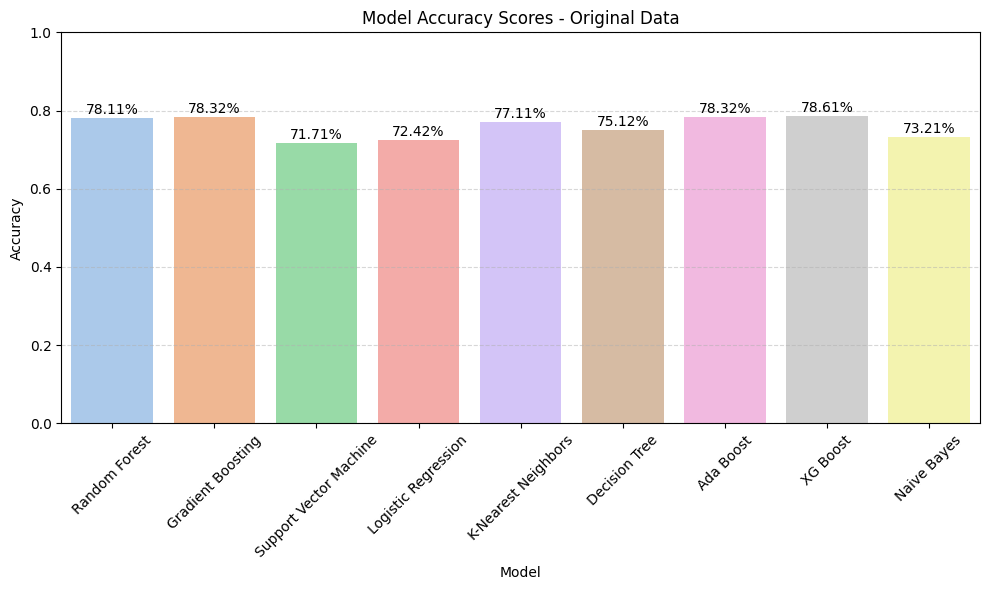

== Model Training & Evaluation ON UPSAMPLED DATA (SMOTEENN) ==
Model: Random Forest
Test Accuracy: 0.962

Model: Gradient Boosting
Test Accuracy: 0.950

Model: Support Vector Machine
Test Accuracy: 0.889

Model: Logistic Regression
Test Accuracy: 0.889

Model: K-Nearest Neighbors
Test Accuracy: 0.974

Model: Decision Tree
Test Accuracy: 0.928

Model: Ada Boost
Test Accuracy: 0.900

Model: XG Boost
Test Accuracy: 0.957

Model: Naive Bayes
Test Accuracy: 0.868



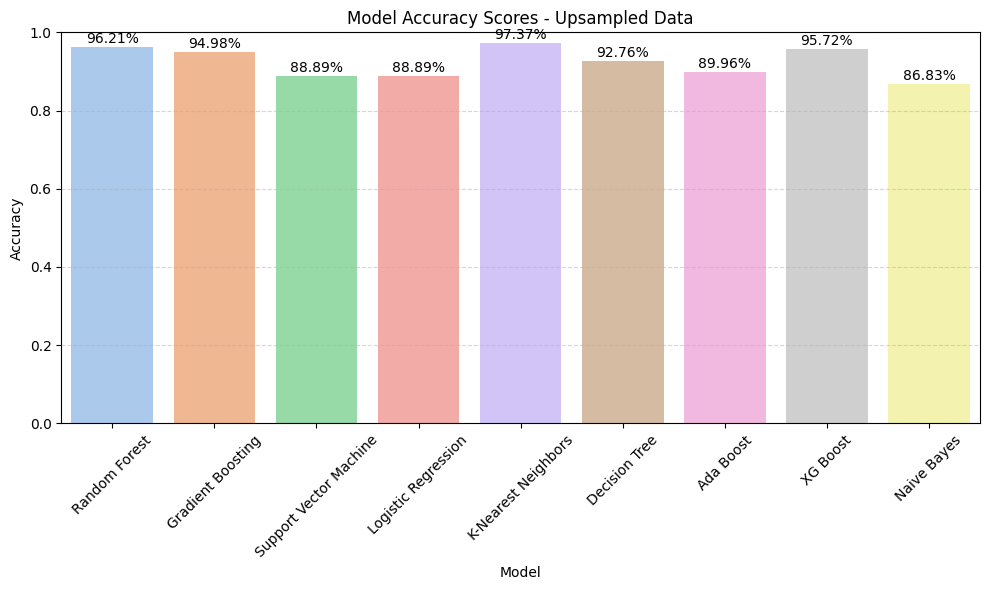

Final Best Model Accuracy (Upsampled data): 0.974


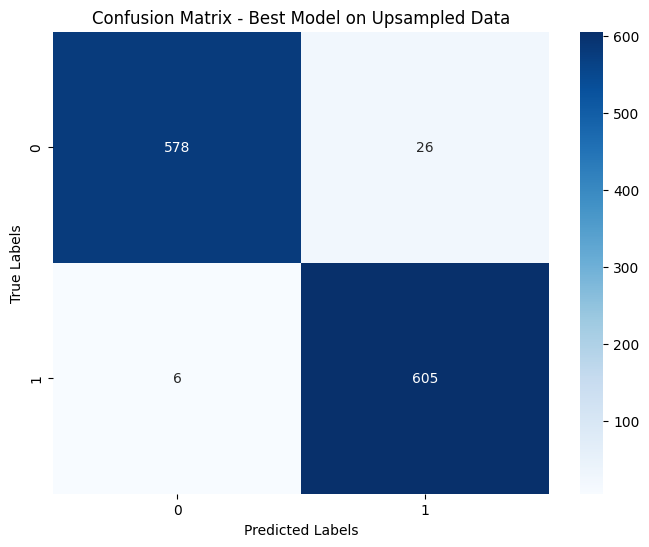

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.97       604
           1       0.96      0.99      0.97       611

    accuracy                           0.97      1215
   macro avg       0.97      0.97      0.97      1215
weighted avg       0.97      0.97      0.97      1215



In [117]:
## Step 9 — Model Training and Evaluation (Original Data, then SMOTEENN Upsampled Data)

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt
import seaborn as sns

# Features and target
X = df_encoded.drop(columns = ["Churn", "customerID"])
X = X.select_dtypes(include = [np.number])
y = df_encoded["Churn"]

models = [
    ('Random Forest', RandomForestClassifier(random_state=42),
        {'n_estimators': [50, 100, 200],
         'max_depth': [None, 10, 20]}),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42),
        {'n_estimators': [50, 100, 200],
         'learning_rate': [0.05, 0.1, 0.5]}),
    ('Support Vector Machine', SVC(random_state=42, class_weight='balanced'),
        {'C': [0.1, 1, 10],
         'gamma': ['scale', 'auto']}),
    ('Logistic Regression', LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear'),
        {'C': [0.1, 1, 10],
         'penalty': ['l1', 'l2']}),
    ('K-Nearest Neighbors', KNeighborsClassifier(),
        {'n_neighbors': [3, 5, 7],
         'weights': ['uniform', 'distance']}),
    ('Decision Tree', DecisionTreeClassifier(random_state=42),
        {'max_depth': [None, 10, 20],
         'min_samples_split': [2, 5, 10]}),
    ('Ada Boost', AdaBoostClassifier(random_state=42),
        {'n_estimators': [50, 100, 200],
         'learning_rate': [0.05, 0.1, 0.5]}),
    ('XG Boost', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
        {'max_depth': randint(3, 6),
         'learning_rate': uniform(0.01, 0.2),
         'n_estimators': randint(100, 300),
         'subsample': uniform(0.8, 0.2)}),
    ('Naive Bayes', GaussianNB(), {})
]

def train_evaluate_models(X_train, y_train, X_test, y_test):
    model_scores = []
    best_model = None
    best_accuracy = 0.0

    for name, model, param_grid in models:
        pipeline = Pipeline([
            ('scaler', MinMaxScaler()),
            ('model', model)
        ])

        if name == 'XG Boost':
            random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                                               n_iter=50, cv=3, verbose=0, random_state=42, n_jobs=-1)
            random_search.fit(X_train, y_train)
            best_estimator = random_search.best_estimator_
            pipeline = Pipeline([('scaler', MinMaxScaler()), ('model', best_estimator)])
        elif param_grid:
            grid_search = GridSearchCV(model, param_grid, cv=2, verbose=0)
            grid_search.fit(X_train, y_train)
            best_estimator = grid_search.best_estimator_
            pipeline = Pipeline([('scaler', MinMaxScaler()), ('model', best_estimator)])
        else:
            pipeline.fit(X_train, y_train)

        pipeline.fit(X_train, y_train)

        y_pred = pipeline.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        model_scores.append({'Model': name, 'Accuracy': accuracy})

        print(f"Model: {name}")
        print(f"Test Accuracy: {accuracy:.3f}")
        print()

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = pipeline

    scores_df = pd.DataFrame(model_scores)
    return best_model, best_accuracy, scores_df


# Split original data - no upsampling
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.2, random_state=42)

print("== Model Training & Evaluation ON ORIGINAL DATA (No Upsampling) ==")
best_model_orig, best_accuracy_orig, scores_df_orig = train_evaluate_models(X_train_orig, y_train_orig, X_test_orig, y_test_orig)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Model', y='Accuracy', data=scores_df_orig, palette='pastel')
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_height() + 0.01,
            f"{p.get_height():.2%}", ha='center')
plt.title("Model Accuracy Scores - Original Data")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Apply SMOTEENN upsampling
from imblearn.combine import SMOTEENN
sm = SMOTEENN(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

# Split upsampled data
X_train_up, X_test_up, y_train_up, y_test_up = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

print("== Model Training & Evaluation ON UPSAMPLED DATA (SMOTEENN) ==")
best_model_up, best_accuracy_up, scores_df_up = train_evaluate_models(X_train_up, y_train_up, X_test_up, y_test_up)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Model', y='Accuracy', data=scores_df_up, palette='pastel')
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_height() + 0.01,
            f"{p.get_height():.2%}", ha='center')
plt.title("Model Accuracy Scores - Upsampled Data")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Final evaluation using best upsampled model
y_pred = best_model_up.predict(X_test_up)
print(f"Final Best Model Accuracy (Upsampled data): {accuracy_score(y_test_up, y_pred):.3f}")

conf_matrix = confusion_matrix(y_test_up, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Best Model on Upsampled Data')
plt.show()

print("Classification Report:\n", classification_report(y_test_up, y_pred))

# Step 10 — Conclusion / Insights
# Model Training & Evaluation Summary

## On Original Data (No Upsampling)
| Model               | Test Accuracy |
|---------------------|---------------|
| Random Forest       | 0.781         |
| Gradient Boosting   | 0.783         |
| Support Vector Machine | 0.717      |
| Logistic Regression | 0.724         |
| K-Nearest Neighbors | 0.771         |
| Decision Tree       | 0.751         |
| Ada Boost           | 0.783         |
| XG Boost            | 0.786         |
| Naive Bayes         | 0.732         |

## On Upsampled Data (SMOTEENN)
| Model               | Test Accuracy |
|---------------------|---------------|
| Random Forest       | 0.962         |
| Gradient Boosting   | 0.950         |
| Support Vector Machine | 0.889      |
| Logistic Regression | 0.889         |
| K-Nearest Neighbors | 0.974         |
| Decision Tree       | 0.928         |
| Ada Boost           | 0.900         |
| XG Boost            | 0.957         |
| Naive Bayes         | 0.868         |

## Final Best Model (Upsampled):
- **Model:** K-Nearest Neighbors
- **Test Accuracy:** 0.974

## Classification Report (Upsampled Data):
| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| 0     | 0.99      | 0.96   | 0.97     | 604     |
| 1     | 0.96      | 0.99   | 0.97     | 611     |
| **Accuracy** |       |        | **0.97** | 1215    |

## Insights:
- Upsampling using SMOTEENN significantly improves the model accuracy and balance between classes.
- K-Nearest Neighbors achieves the highest accuracy (0.974) on the balanced dataset.
- Models generally show higher performance with upsampled data compared to original imbalanced data.
- Balanced precision and recall indicate robust model performance for both classes.
- Addressing class imbalance is crucial in improving the detection of minority class.


*


In [119]:
feature_names = list(X.columns)
print(feature_names)


['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'AvgChargesPerMonth', 'HighMonthlyCharges', 'LongTenure']


In [120]:
best_model_up

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 KNeighborsClassifier(n_neighbors=3, weights='distance'))])

In [118]:
import joblib
import os

# Create a directory to save model artifacts
model_dir = "model"
os.makedirs(model_dir, exist_ok=True)

# Assuming `best_model_up` is your final chosen model trained on upsampled data
# Save the trained model pipeline
model_path = os.path.join(model_dir, "churn_model.pkl")
joblib.dump(best_model_up, model_path)
print(f"Model saved to {model_path}")

# If you have any separate scalers or encoders, save them too
# For example, if you had a scaler separately saved (here scaler is within pipeline)
# scaler_path = os.path.join(model_dir, "scaler.pkl")
# joblib.dump(scaler, scaler_path)
# print(f"Scaler saved to {scaler_path}")


Model saved to model\churn_model.pkl


# MLFLOW WORKFLOW

In [139]:
import mlflow
import mlflow.sklearn

# Start MLflow run
with mlflow.start_run():
    # Log model parameters
    mlflow.log_param("model_type", best_model_up.named_steps['model'].__class__.__name__)
    mlflow.log_param("features", list(X.columns))
    
    # Log metrics (accuracy)
    mlflow.log_metric("accuracy", best_accuracy_up)
    
    # Log the trained model pipeline (includes scaling, preprocessing)
    mlflow.sklearn.log_model(best_model_up, "model")
    
    print(f"MLflow run id: {mlflow.active_run().info.run_id}")


2025/09/24 14:10:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/24 14:10:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow run id: 93a5106f3554472b87cfcfbbdb4e8600


In [148]:
import mlflow
import mlflow.sklearn
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

# Convert object dtype columns to category type for XGBoost compat
for col in X_train.select_dtypes(include='object').columns:
    X_train[col] = X_train[col].astype('category')
for col in X_test.select_dtypes(include='object').columns:
    X_test[col] = X_test[col].astype('category')

categorical_cols = list(X_train.select_dtypes(include='category').columns)
numeric_cols = list(X_train.select_dtypes(include=['int64', 'float64']).columns)

models = [
    ('Random Forest', RandomForestClassifier(), None),
    ('Gradient Boosting', GradientBoostingClassifier(), None),
    ('Support Vector Machine', SVC(), None),
    ('Logistic Regression', LogisticRegression(max_iter=1000), None),
    ('K-Nearest Neighbors', KNeighborsClassifier(), None),
    ('Decision Tree', DecisionTreeClassifier(), None),
    ('Ada Boost', AdaBoostClassifier(), None),
    ('XG Boost', XGBClassifier(enable_categorical=True, use_label_encoder=False, eval_metric='logloss'), {
        "n_estimators": [100, 200],
        "max_depth": [3, 5],
        "learning_rate": [0.01, 0.1]
    }),
    ('Naive Bayes', GaussianNB(), None),
]

mlflow.set_experiment('Telco_Churn_Models_Final_NoXGBParam')

model_scores = []
best_accuracy = 0.0
best_model_name = None
best_run_id = None

for name, model, param_grid in models:
    with mlflow.start_run(run_name=name) as run:
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numeric_cols),
                ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
            ])

        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

        if name == 'XG Boost' and param_grid is not None:
            random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                                               n_iter=20, cv=3, verbose=0, random_state=42, n_jobs=-1)
            random_search.fit(X_train, y_train)
            best_estimator = random_search.best_estimator_
            pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('model', best_estimator)
            ])
            pipeline.fit(X_train, y_train)

        elif param_grid is not None:
            grid_search = GridSearchCV(model, param_grid, cv=3, verbose=0)
            grid_search.fit(X_train, y_train)
            best_estimator = grid_search.best_estimator_
            pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('model', best_estimator)
            ])
            pipeline.fit(X_train, y_train)

            # Log parameters for non-XGBoost models only
            mlflow.log_params(grid_search.best_params_)

        else:
            pipeline.fit(X_train, y_train)

        y_pred = pipeline.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        # Log metrics for all
        mlflow.log_metric('test_accuracy', accuracy)

        # Log model artifact
        mlflow.sklearn.log_model(pipeline, artifact_path='model')

        # Confusion matrix artifact
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6,4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix - {name}')
        cm_path = f'confusion_matrix_{name}.png'
        plt.savefig(cm_path)
        plt.close()

        mlflow.log_artifact(cm_path)
        os.remove(cm_path)

        print(f"Model: {name} | Accuracy: {accuracy:.3f} | Run id: {run.info.run_id}")

        model_scores.append({'Model': name, 'Accuracy': accuracy})

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model_name = name
            best_run_id = run.info.run_id

if best_run_id:
    model_uri = f"runs:/{best_run_id}/model"
    mlflow.register_model(model_uri, best_model_name)
    print(f"Registered best model '{best_model_name}' with run ID {best_run_id}")

scores_df = pd.DataFrame(model_scores)
print(scores_df)


2025/09/24 15:05:55 INFO mlflow.tracking.fluent: Experiment with name 'Telco_Churn_Models_Final_NoXGBParam' does not exist. Creating a new experiment.
2025/09/24 15:05:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/24 15:06:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: Random Forest | Accuracy: 0.779 | Run id: ccad94640e56495a80f0e68ff3c585b8


2025/09/24 15:06:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/24 15:06:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: Gradient Boosting | Accuracy: 0.798 | Run id: 86f7b32c12e24659a80e0d99008dee1d


2025/09/24 15:06:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/24 15:06:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: Support Vector Machine | Accuracy: 0.794 | Run id: bb18a198519541539a27dd459b62bb47


2025/09/24 15:06:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/24 15:06:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/09/24 15:06:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model: Logistic Regression | Accuracy: 0.800 | Run id: 2e90d896a99243619c4d52dd89a5c376


2025/09/24 15:06:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/09/24 15:06:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model: K-Nearest Neighbors | Accuracy: 0.753 | Run id: 17ddf343e2e04814b8829726d0c7dd32


2025/09/24 15:06:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: Decision Tree | Accuracy: 0.729 | Run id: 7953708e7ddd40619f5d4bdd3e48599b


2025/09/24 15:06:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/24 15:06:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: Ada Boost | Accuracy: 0.794 | Run id: 8903a4b673dd46e39163c8e2d1b933ea


2025/09/24 15:06:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/24 15:06:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/09/24 15:06:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model: XG Boost | Accuracy: 0.790 | Run id: d27fa6c100c94739994057b910c8c4ab


2025/09/24 15:06:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: Naive Bayes | Accuracy: 0.688 | Run id: 9e2d52869ced468ba7da0f235b93cec1


Successfully registered model 'Logistic Regression'.
2025/09/24 15:06:58 WARNING mlflow.tracking._model_registry.fluent: Run with id 2e90d896a99243619c4d52dd89a5c376 has no artifacts at artifact path 'model', registering model based on models:/m-2eac98bee64e4496b638c1ce88a0cd98 instead


Registered best model 'Logistic Regression' with run ID 2e90d896a99243619c4d52dd89a5c376
                    Model  Accuracy
0           Random Forest  0.778975
1       Gradient Boosting  0.797501
2  Support Vector Machine  0.793623
3     Logistic Regression  0.800086
4     K-Nearest Neighbors  0.753124
5           Decision Tree  0.728565
6               Ada Boost  0.794485
7                XG Boost  0.790177
8             Naive Bayes  0.687635


Created version '1' of model 'Logistic Regression'.


In [149]:
import mlflow
import mlflow.sklearn
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from imblearn.combine import SMOTEENN

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# Assuming your base X, y before upsampling
sm = SMOTEENN(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

X_train_up, X_test_up, y_train_up, y_test_up = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Convert object dtype columns to category type
for col in X_train_up.select_dtypes(include='object').columns:
    X_train_up[col] = X_train_up[col].astype('category')
for col in X_test_up.select_dtypes(include='object').columns:
    X_test_up[col] = X_test_up[col].astype('category')

categorical_cols = list(X_train_up.select_dtypes(include='category').columns)
numeric_cols = list(X_train_up.select_dtypes(include=['int64', 'float64']).columns)

models = [
    ('Random Forest', RandomForestClassifier(), None),
    ('Gradient Boosting', GradientBoostingClassifier(), None),
    ('Support Vector Machine', SVC(), None),
    ('Logistic Regression', LogisticRegression(max_iter=1000), None),
    ('K-Nearest Neighbors', KNeighborsClassifier(), None),
    ('Decision Tree', DecisionTreeClassifier(), None),
    ('Ada Boost', AdaBoostClassifier(), None),
    ('Naive Bayes', GaussianNB(), None),
]

mlflow.set_experiment('Telco_Churn_Models_Upsampled_NoXGB')

model_scores = []
best_accuracy = 0.0
best_model_name = None
best_run_id = None

for name, model, param_grid in models:
    with mlflow.start_run(run_name=name) as run:
        preprocessor = ColumnTransformer([
            ('num', StandardScaler(), numeric_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
        ])

        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

        if param_grid is not None:
            grid_search = GridSearchCV(model, param_grid, cv=3)
            grid_search.fit(X_train_up, y_train_up)
            best_estimator = grid_search.best_estimator_
            pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('model', best_estimator)
            ])
            pipeline.fit(X_train_up, y_train_up)
            mlflow.log_params(grid_search.best_params_)

        else:
            pipeline.fit(X_train_up, y_train_up)

        y_pred = pipeline.predict(X_test_up)
        accuracy = accuracy_score(y_test_up, y_pred)

        mlflow.log_param('model_name', name)
        mlflow.log_metric('test_accuracy', accuracy)

        mlflow.sklearn.log_model(pipeline, artifact_path='model')

        cm = confusion_matrix(y_test_up, y_pred)
        plt.figure(figsize=(6,4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix - {name}')
        cm_path = f'confusion_matrix_{name}.png'
        plt.savefig(cm_path)
        plt.close()

        mlflow.log_artifact(cm_path)
        os.remove(cm_path)

        print(f"Model: {name} | Accuracy: {accuracy:.3f} | Run id: {run.info.run_id}")

        model_scores.append({'Model': name, 'Accuracy': accuracy})

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model_name = name
            best_run_id = run.info.run_id

if best_run_id:
    model_uri = f"runs:/{best_run_id}/model"
    mlflow.register_model(model_uri, best_model_name)
    print(f"Registered best model '{best_model_name}' with run ID {best_run_id}")

scores_df = pd.DataFrame(model_scores)
print(scores_df)


2025/09/24 15:16:37 INFO mlflow.tracking.fluent: Experiment with name 'Telco_Churn_Models_Upsampled_NoXGB' does not exist. Creating a new experiment.
2025/09/24 15:16:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/24 15:16:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: Random Forest | Accuracy: 0.962 | Run id: 81959128e4724aa388436dbbc9dc0a39


2025/09/24 15:16:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/24 15:16:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: Gradient Boosting | Accuracy: 0.912 | Run id: 596862c0fde340cf87d7c99fe9b65ddf


2025/09/24 15:16:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/24 15:16:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/09/24 15:16:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model: Support Vector Machine | Accuracy: 0.881 | Run id: bd626b0fc1cb4218ab0fe3a91dde21d7


2025/09/24 15:17:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/09/24 15:17:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model: Logistic Regression | Accuracy: 0.887 | Run id: e72ae8a9d86b495c8b078776920959b3


2025/09/24 15:17:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/09/24 15:17:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model: K-Nearest Neighbors | Accuracy: 0.946 | Run id: d76f5b1b78754f67a74bb0db41aca049


2025/09/24 15:17:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: Decision Tree | Accuracy: 0.935 | Run id: 9e85f6b9b56a4906b86f7b63b075362c


2025/09/24 15:17:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/24 15:17:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/09/24 15:17:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model: Ada Boost | Accuracy: 0.898 | Run id: 73a4f89dc20e4fbe85c348c2fa9b898d


2025/09/24 15:17:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'Random Forest'.
2025/09/24 15:17:29 WARNING mlflow.tracking._model_registry.fluent: Run with id 81959128e4724aa388436dbbc9dc0a39 has no artifacts at artifact path 'model', registering model based on models:/m-27f92eeb3c554387b1d0d7ef619f86c1 instead


Model: Naive Bayes | Accuracy: 0.868 | Run id: 6689a25d25134aa8b88a7965b20e93ad
Registered best model 'Random Forest' with run ID 81959128e4724aa388436dbbc9dc0a39
                    Model  Accuracy
0           Random Forest  0.962140
1       Gradient Boosting  0.911934
2  Support Vector Machine  0.880658
3     Logistic Regression  0.887243
4     K-Nearest Neighbors  0.945679
5           Decision Tree  0.934979
6               Ada Boost  0.897942
7             Naive Bayes  0.868313


Created version '1' of model 'Random Forest'.


2025/09/24 15:23:05 INFO mlflow.tracking.fluent: Experiment with name 'Telco_Churn_Models_Upsampled_With_Metrics' does not exist. Creating a new experiment.
2025/09/24 15:23:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/24 15:23:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: Random Forest | Accuracy: 0.963 | Run id: b880b8c7b0744de09cd27b1972d89b98


2025/09/24 15:23:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/24 15:23:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: Gradient Boosting | Accuracy: 0.912 | Run id: df5b697b11c448f9a0527f62b897b39b


2025/09/24 15:23:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/24 15:23:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/09/24 15:23:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model: Support Vector Machine | Accuracy: 0.881 | Run id: ead71ba7c8ac4383a5769000b3527930


2025/09/24 15:23:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/09/24 15:23:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model: Logistic Regression | Accuracy: 0.887 | Run id: dcb32c21c23e4d85ae449de13ebd89e2


2025/09/24 15:23:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/09/24 15:23:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model: K-Nearest Neighbors | Accuracy: 0.946 | Run id: 0e33e7835a2e40eb90898af6f40f2851


2025/09/24 15:23:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model: Decision Tree | Accuracy: 0.937 | Run id: 343a02ea8d134d45a18fa6085f5ee5e7


2025/09/24 15:23:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/24 15:23:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/09/24 15:23:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model: Ada Boost | Accuracy: 0.898 | Run id: 1dfe8a0cdc0543d1abf8e69c21ce358f


2025/09/24 15:23:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'Random Forest' already exists. Creating a new version of this model...
2025/09/24 15:23:57 WARNING mlflow.tracking._model_registry.fluent: Run with id b880b8c7b0744de09cd27b1972d89b98 has no artifacts at artifact path 'model', registering model based on models:/m-3236ccd2504a4305a5bcfb81270f2f44 instead


Model: Naive Bayes | Accuracy: 0.868 | Run id: 566d8a86ccb54863b320e9d317dc4ce9
Registered best model 'Random Forest' with run ID b880b8c7b0744de09cd27b1972d89b98
                    Model  Accuracy
0           Random Forest  0.962963
1       Gradient Boosting  0.911934
2  Support Vector Machine  0.880658
3     Logistic Regression  0.887243
4     K-Nearest Neighbors  0.945679
5           Decision Tree  0.937449
6               Ada Boost  0.897942
7             Naive Bayes  0.868313


Created version '2' of model 'Random Forest'.


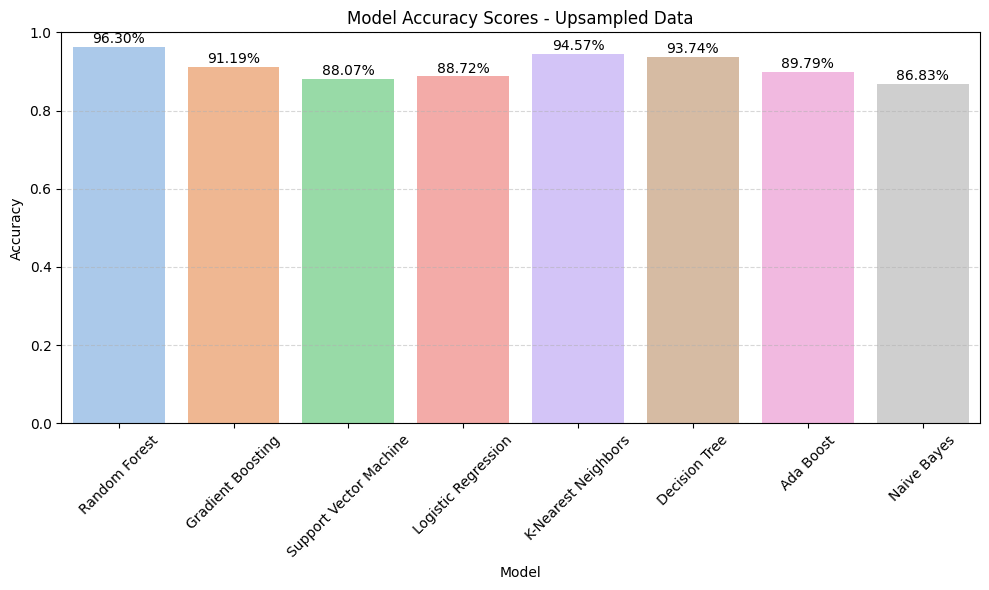

In [150]:
import mlflow
import mlflow.sklearn
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from imblearn.combine import SMOTEENN

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# Assuming your base X, y before upsampling
sm = SMOTEENN(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

X_train_up, X_test_up, y_train_up, y_test_up = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Convert object dtype columns to category dtype
for col in X_train_up.select_dtypes(include='object').columns:
    X_train_up[col] = X_train_up[col].astype('category')
for col in X_test_up.select_dtypes(include='object').columns:
    X_test_up[col] = X_test_up[col].astype('category')

categorical_cols = list(X_train_up.select_dtypes(include='category').columns)
numeric_cols = list(X_train_up.select_dtypes(include=['int64', 'float64']).columns)

models = [
    ('Random Forest', RandomForestClassifier(), None),
    ('Gradient Boosting', GradientBoostingClassifier(), None),
    ('Support Vector Machine', SVC(), None),
    ('Logistic Regression', LogisticRegression(max_iter=1000), None),
    ('K-Nearest Neighbors', KNeighborsClassifier(), None),
    ('Decision Tree', DecisionTreeClassifier(), None),
    ('Ada Boost', AdaBoostClassifier(), None),
    ('Naive Bayes', GaussianNB(), None),
]

mlflow.set_experiment('Telco_Churn_Models_Upsampled_With_Metrics')

model_scores = []
best_accuracy = 0.0
best_model = None
best_model_name = None
best_run_id = None

for name, model, param_grid in models:
    with mlflow.start_run(run_name=name) as run:
        preprocessor = ColumnTransformer([
            ('num', StandardScaler(), numeric_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
        ])

        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

        if param_grid is not None:
            grid_search = GridSearchCV(model, param_grid, cv=3)
            grid_search.fit(X_train_up, y_train_up)
            best_estimator = grid_search.best_estimator_
            pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('model', best_estimator)
            ])
            pipeline.fit(X_train_up, y_train_up)
            mlflow.log_params(grid_search.best_params_)
        else:
            pipeline.fit(X_train_up, y_train_up)

        y_pred = pipeline.predict(X_test_up)
        accuracy = accuracy_score(y_test_up, y_pred)

        # Log metrics and params
        mlflow.log_param('model_name', name)
        mlflow.log_metric('test_accuracy', accuracy)

        # Log full model pipeline
        mlflow.sklearn.log_model(pipeline, artifact_path='model')

        # Classification report as text artifact
        cls_report = classification_report(y_test_up, y_pred, output_dict=True)
        report_df = pd.DataFrame(cls_report).transpose()
        report_path = f"classification_report_{name}.csv"
        report_df.to_csv(report_path)
        mlflow.log_artifact(report_path)
        os.remove(report_path)

        # Plot and log confusion matrix
        cm = confusion_matrix(y_test_up, y_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix - {name}')
        cm_path = f'confusion_matrix_{name}.png'
        plt.savefig(cm_path)
        plt.close()
        mlflow.log_artifact(cm_path)
        os.remove(cm_path)

        print(f"Model: {name} | Accuracy: {accuracy:.3f} | Run id: {run.info.run_id}")

        model_scores.append({'Model': name, 'Accuracy': accuracy})

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = pipeline
            best_model_name = name
            best_run_id = run.info.run_id

if best_run_id:
    model_uri = f"runs:/{best_run_id}/model"
    mlflow.register_model(model_uri, best_model_name)
    print(f"Registered best model '{best_model_name}' with run ID {best_run_id}")

scores_df = pd.DataFrame(model_scores)
print(scores_df)

# Plot model accuracies
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Model', y='Accuracy', data=scores_df, palette='pastel')
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_height() + 0.01,
            f"{p.get_height():.2%}", ha='center')
plt.title("Model Accuracy Scores - Upsampled Data")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
